# Movies Revenues Forecast: Predicitve Modeling

## Import Data

In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from dotenv import load_dotenv
from urllib.parse import quote_plus
plt.style.use("ggplot")

In [3]:
# Connect to DB
load_dotenv()

password = quote_plus(os.getenv("DB_PASS"))
dbname = os.getenv("DB_NAME")

connection_str = f"postgresql+psycopg2://postgres:{password}@{dbname}"
engine = create_engine(connection_str)

In [4]:
movie_cleaned_df = pd.read_sql('SELECT * FROM movie_cleaned_df', engine)

## Target Variable

In [5]:
movie_cleaned_df['made_profit'] = (movie_cleaned_df['revenue'] > movie_cleaned_df['budget']).astype(int)

## Save final data frame to CSV

In [6]:
movie_cleaned_df.to_csv('final_movies_dashboard_dataset.csv', index=False)

## Preprocessing 

In [7]:
# High leakage columns
movie_cleaned_df_model = movie_cleaned_df.drop(columns=['release_date', 'revenue', 
                                                        'original_title', 'keywords', 
                                                        'production_companies_list', 'production_countries_list',
                                                        'vote_average', 'budget', 'runtime', 'id'])

In [8]:
# Encode Categorical Features
movie_cleaned_df_model = pd.get_dummies(movie_cleaned_df_model, columns=['genres', 'original_language'], drop_first=True)

In [9]:
# Drop Missing Values
movie_cleaned_df_model = movie_cleaned_df_model.dropna()

## Train and Test

In [10]:
X = movie_cleaned_df_model.drop('made_profit', axis=1)
y = movie_cleaned_df_model['made_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model

In [11]:
movie_model = LogisticRegression(max_iter=1000)
movie_model.fit(X_train, y_train)

y_pred = movie_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7523219814241486
[[  1 158]
 [  2 485]]
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       159
           1       0.75      1.00      0.86       487

    accuracy                           0.75       646
   macro avg       0.54      0.50      0.44       646
weighted avg       0.65      0.75      0.65       646



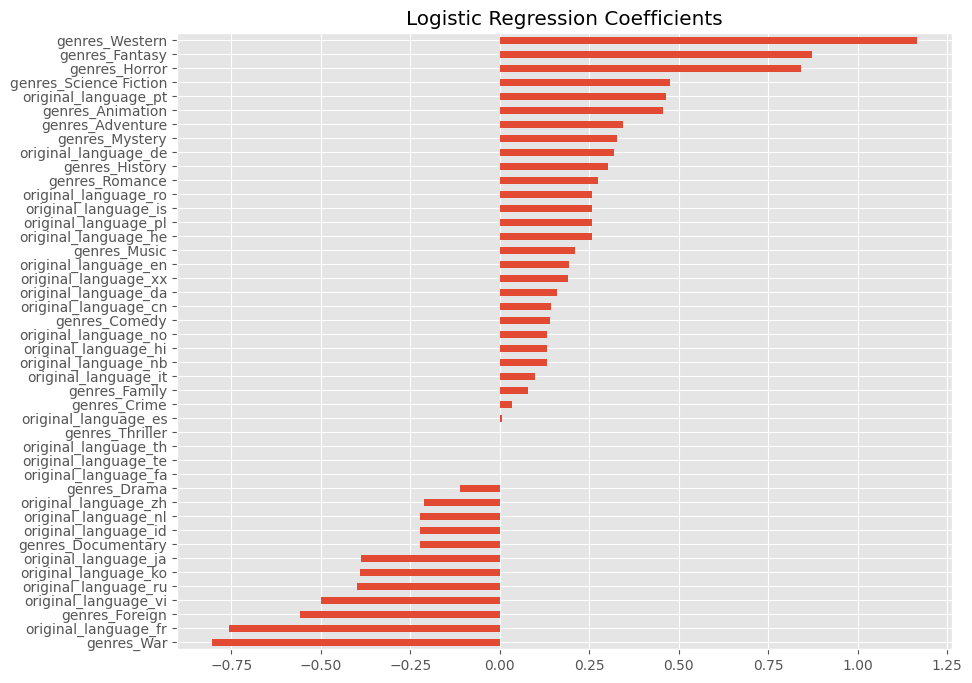

In [12]:
feature_importance = pd.Series(movie_model.coef_[0], index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10,8), title='Logistic Regression Coefficients')
plt.show()

## Key Insights

### Quesion 1: Which Genres most affect movie success

Top 3 Genres that are most likely to turn a proft

    1. Western
    2. Horror
    3. Fantasy

Top 3 Genres that decrease the odds of 

    1. War
    2. Foreign
    3. Drama

### Quesion 2: Which languages most affect movie success

Top 3 Languages that are most likely to turn a proft

    1. German
    2. Portuguese 
    3. English

Top 3 Language that decrease the odds of success

    1. French
    2. Japanese
    3. Vietnamese

###  Interesting Findings

1. Movies made in German and Portuguese yield a higher profit than English Movies.
2. Western Movies are the most profitable type of movies.

In [13]:
# Other Models -> Random Forests, XGboost, GradientBoosting

## Random Forest Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [15]:
rf_movie_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_movie_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf_movie_model.predict(X_test)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7538699690402477
Confusion Matrix:
 [[  1 158]
 [  1 486]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.01      0.01       159
           1       0.75      1.00      0.86       487

    accuracy                           0.75       646
   macro avg       0.63      0.50      0.44       646
weighted avg       0.69      0.75      0.65       646

Precision: 0.7546583850931677
Recall: 0.997946611909651
F1 Score: 0.8594164456233422


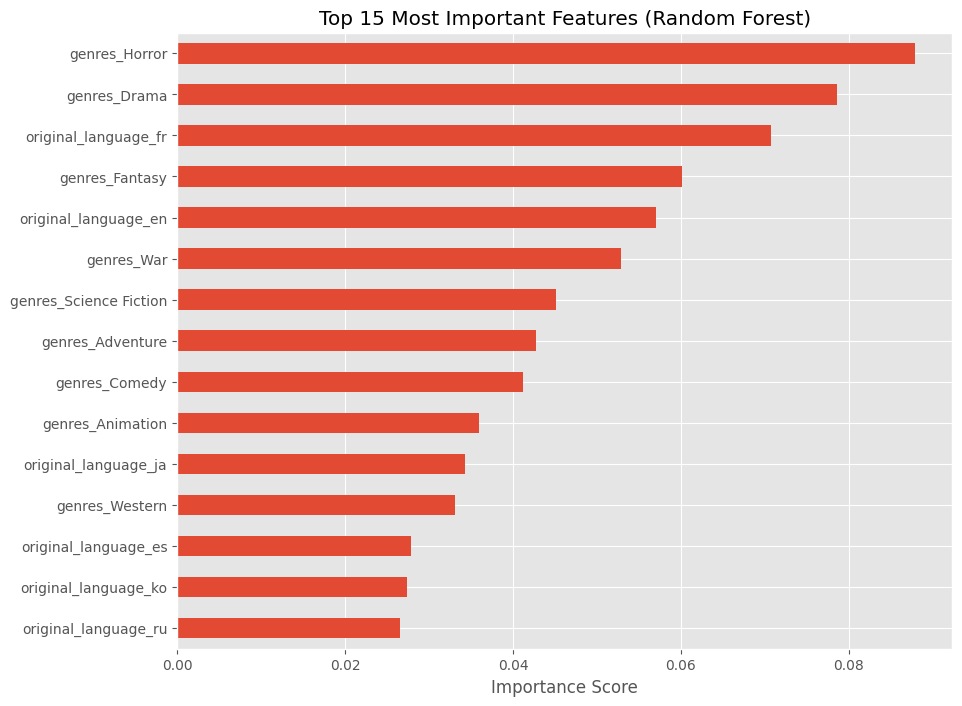

In [18]:
feature_importances = pd.Series(rf_movie_model.feature_importances_, index=X.columns)
feature_importances.sort_values().tail(15).plot(kind='barh', figsize=(10, 8))
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

## XGBoost Model

In [19]:
from xgboost import XGBClassifier

In [20]:
xgb_movie_model = XGBClassifier(#use_label_encoder=False, 
    eval_metric='logloss', random_state=42)
xgb_movie_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [21]:
y_pred_xgb = xgb_movie_model.predict(X_test)

In [22]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost F1 Score:", f1_score(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7538699690402477
XGBoost F1 Score: 0.8594164456233422
XGBoost Confusion Matrix:
 [[  1 158]
 [  1 486]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.01      0.01       159
           1       0.75      1.00      0.86       487

    accuracy                           0.75       646
   macro avg       0.63      0.50      0.44       646
weighted avg       0.69      0.75      0.65       646



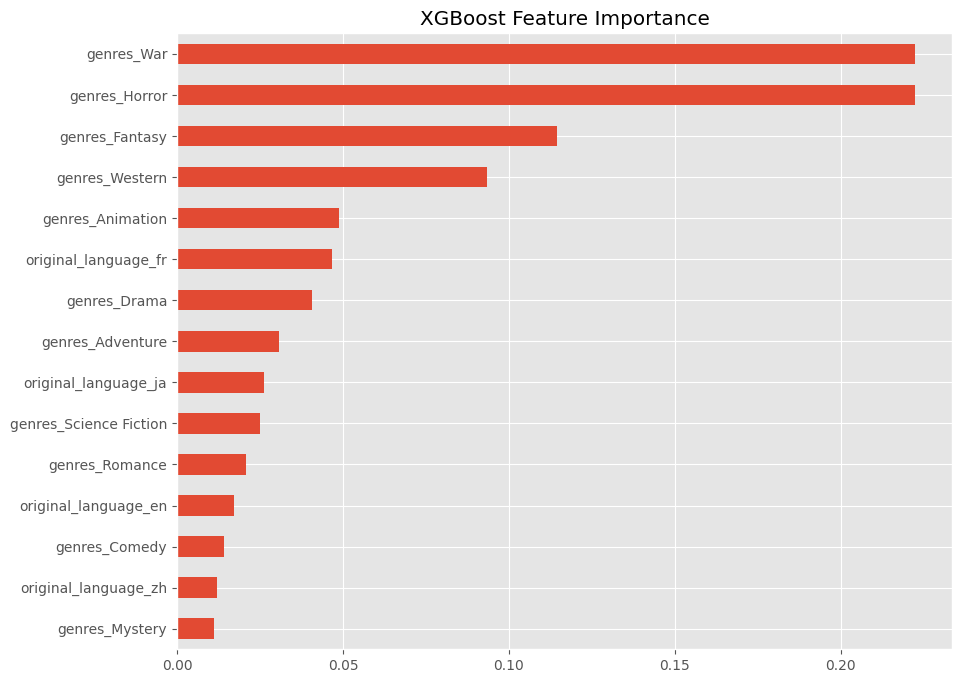

In [23]:
feature_importance = pd.Series(xgb_movie_model.feature_importances_, index=X.columns)
feature_importance.sort_values().tail(15).plot(kind='barh', figsize=(10, 8))
plt.title("XGBoost Feature Importance")
plt.show()

## Model Accuracy - Confusion Matrix

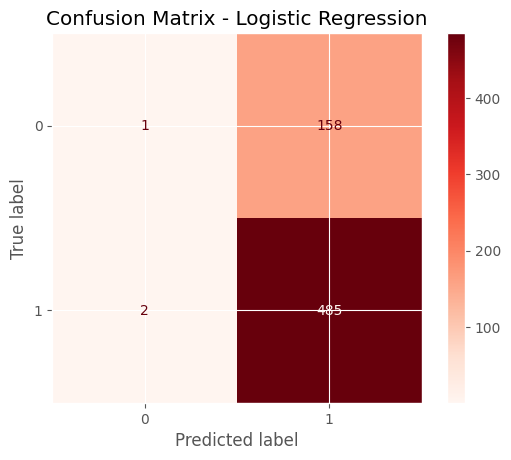

In [30]:
ConfusionMatrixDisplay.from_estimator(movie_model, X_test, y_test, cmap='Reds')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()